In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
from time import time
import matplotlib.pyplot as plt

import DynamicTimeAllocationModel

path = 'output/'

# c++ settings
do_compile = True
threads = 1

# from EconModel import cpptools
# cpptools.setup_nlopt(folder='cppfuncs/', do_print=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TO DO (precomputation):
1. Thorough test that it works
2. Numerical inverse?


Have done:
1. New model setup in py-file
2. Precomputation of intratemporal allocation for singles
3. Precompute marginal utility for singles
4. Precomputation of intratemporal allocation for couples
5. Precomputation of marginal utility for couples 
6. Fix imprecision issues at the bottom of the Ctot grid (bit ad hoc but it sort of works)

# Solve and simulate from alternative models

Benchmark model settings

In [12]:
settings = { 
       'T':20,
       'num_A': 10,
       'num_K': 10,
       'num_power': 11,
       'num_love': 15,

       'num_Ctot': 30,

       'phi_w': 1.0,
       'phi_m': 1.0,

       'threads':threads,
       'do_egm': True,
       }

Solve application model

In [13]:
model = DynamicTimeAllocationModel.HouseholdModelClass(par=settings)
model.link_to_cpp(force_compile=do_compile)
%time model.solve()

par = model.par
sol = model.sol

CPU times: total: 1.73 s
Wall time: 1.75 s


## Precomputation: Singles

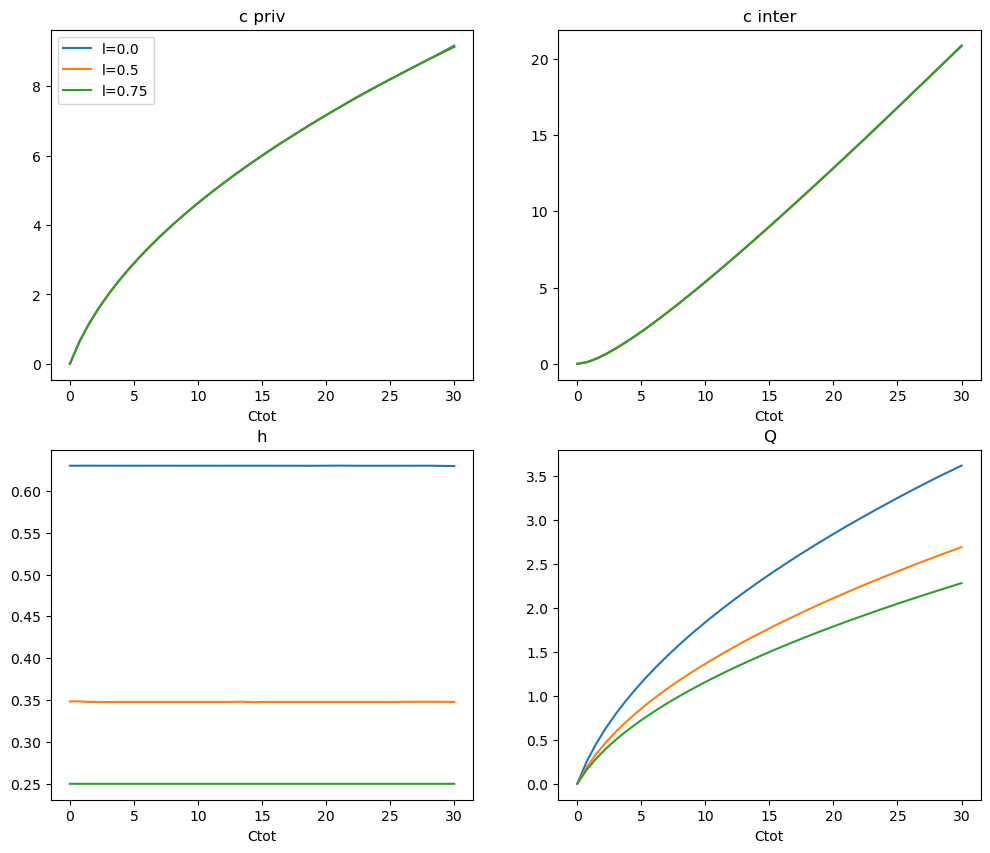

In [14]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

for i,l in enumerate(model.par.grid_l):
    ax[0,0].plot(model.par.grid_Ctot, model.sol.pre_Cw_priv_single[i,:], label=f'l={l}')
    ax[0,0].set_title('c priv')
    ax[0,0].set_xlabel('Ctot')
    ax[0,0].legend()

    ax[0,1].plot(model.par.grid_Ctot, model.sol.pre_Cw_inter_single[i,:], label=f'l={l}')
    ax[0,1].set_title('c inter')
    ax[0,1].set_xlabel('Ctot')

    ax[1,0].plot(model.par.grid_Ctot[:], model.sol.pre_hw_single[i,:], label=f'l={l}')
    ax[1,0].set_title('h')
    ax[1,0].set_xlabel('Ctot')

    ax[1,1].plot(model.par.grid_Ctot, model.sol.pre_Qw_single[i,:], label=f'l={l}')
    ax[1,1].set_title('Q')
    ax[1,1].set_xlabel('Ctot')



AMO: h is constant in Ctot due to the Cobb Douglas production function giving cross elasticities of zero. with a more general production function, h depends on Ctot (I've checked this). This is also why marginal utility does not depend on labor supply, see below. 

Text(0.5, 1.0, 'Marginal utility, singles')

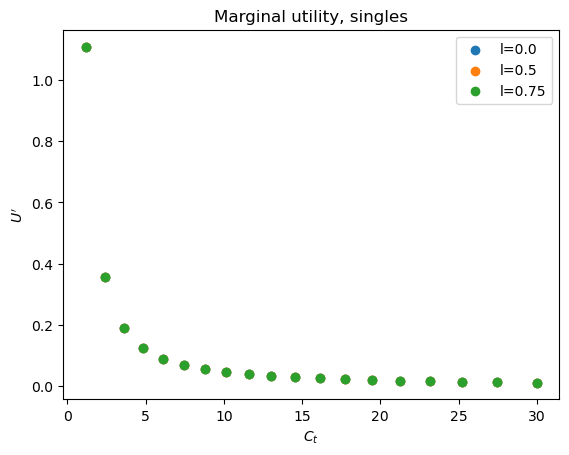

In [15]:
for il in range(par.num_l):
    plt.scatter(par.grid_C_for_marg_u[1:], par.grid_marg_u_single_m[il, 1:], label=f'l={par.grid_l[il]}')
plt.legend()
plt.xlabel('$C_t$')
plt.ylabel('$U\'$')
plt.title("Marginal utility, singles")

## Precomputation: Couples

In [21]:
model.cpp.delink()
model.link_to_cpp(force_compile=do_compile, do_print=False)
model.solve()

par = model.par
sol = model.sol

In [22]:
def plot_variable_l_by_l(varname, container, iPs, x_axis):
    fig, ax = plt.subplots(3,3, figsize=(15,15))
    variable = getattr(container, varname)

    for ilw,lw in enumerate(model.par.grid_l):
        for ilm, lm in enumerate(model.par.grid_l):
            for iP in iPs:
                ax[ilw, ilm].plot(x_axis, variable[ilw, ilm, :, iP], label=f'p={par.grid_power[iP] :5.2f}')
                ax[ilw, ilm].scatter(x_axis, variable[ilw, ilm, :, iP], s=10)


            ax[ilw, ilm].set_title(f'lw={lw}, lm={lm}')
            ax[ilw, ilm].set_xlabel('Ctot')
            ax[ilw, ilm].legend()


iPs = [1, 5, 9]

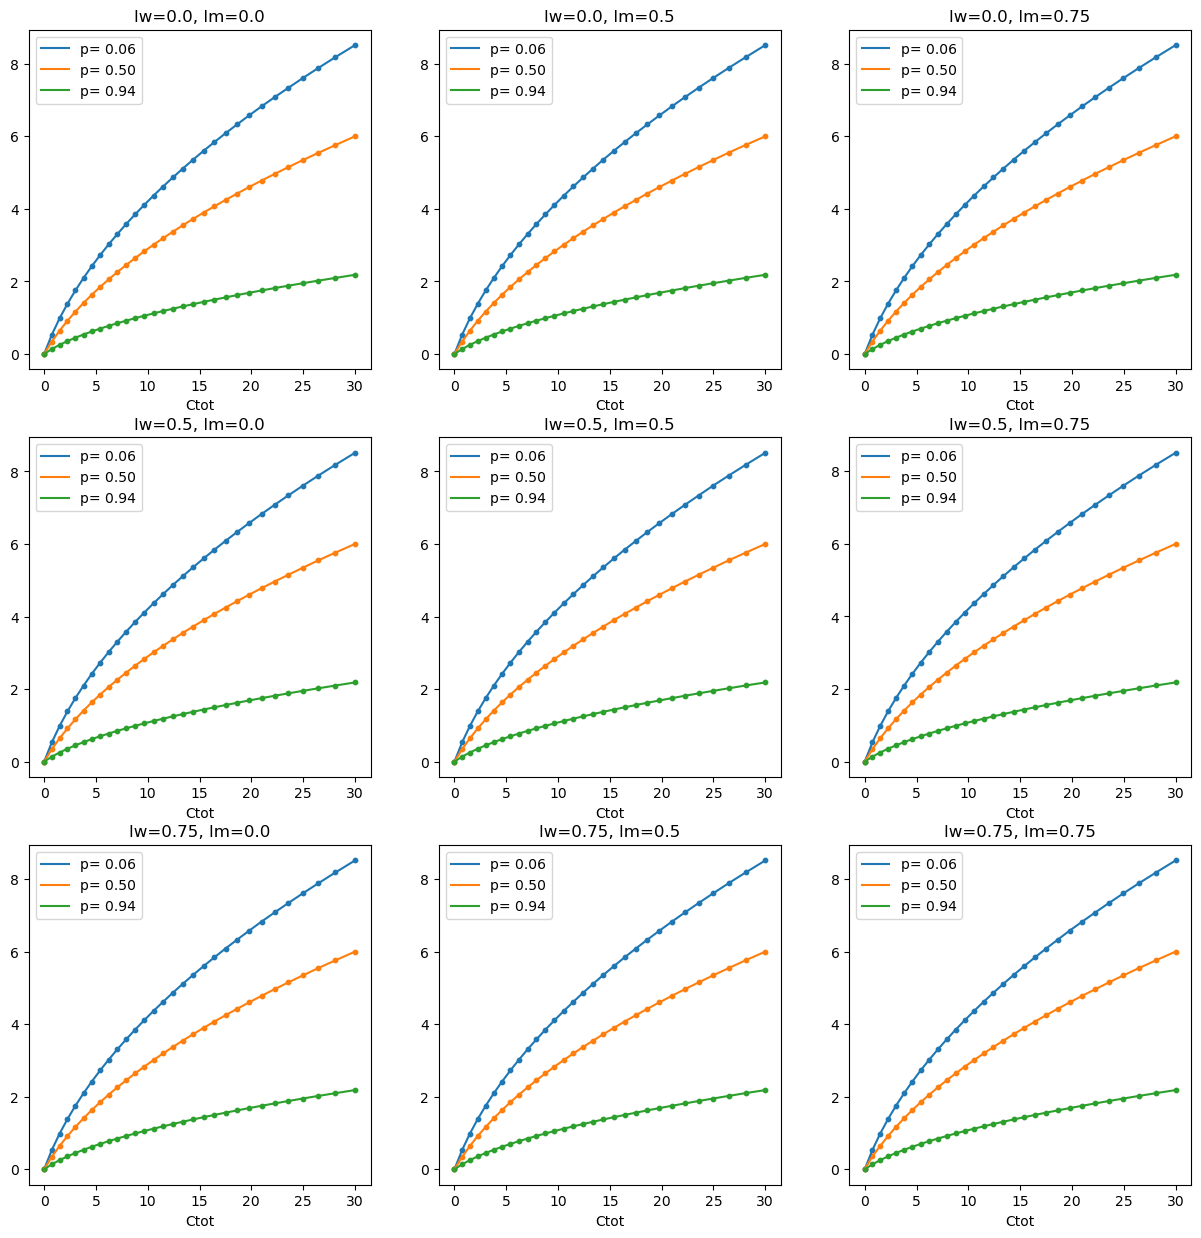

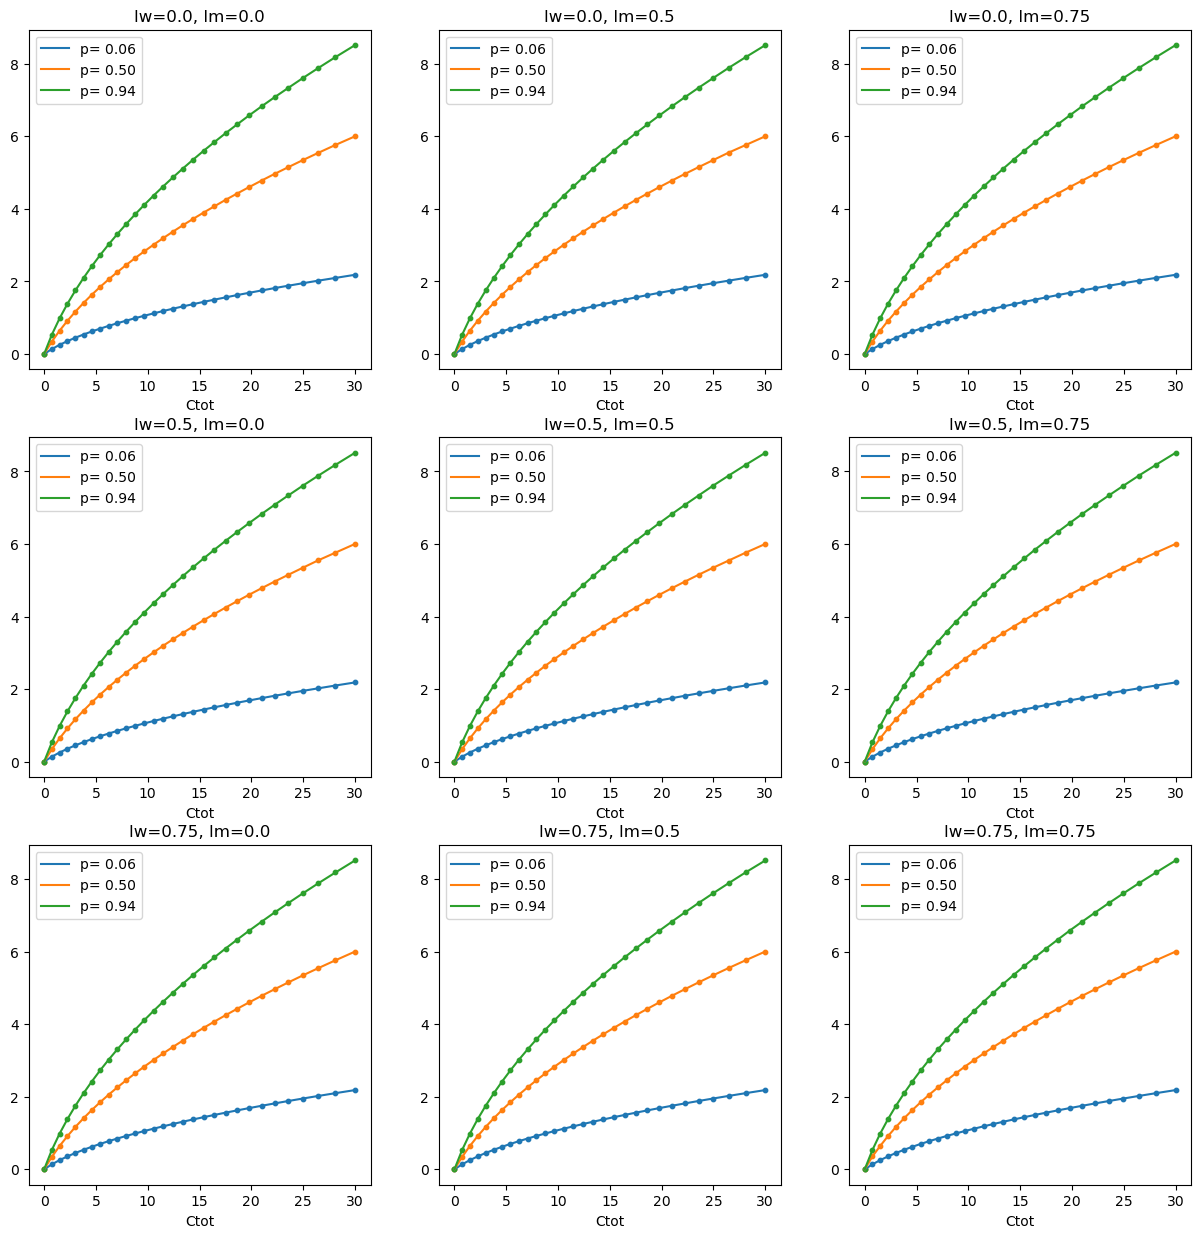

In [23]:
plot_variable_l_by_l('pre_Cm_priv_couple', model.sol, iPs, par.grid_Ctot)
plot_variable_l_by_l('pre_Cw_priv_couple', model.sol, iPs, par.grid_Ctot)

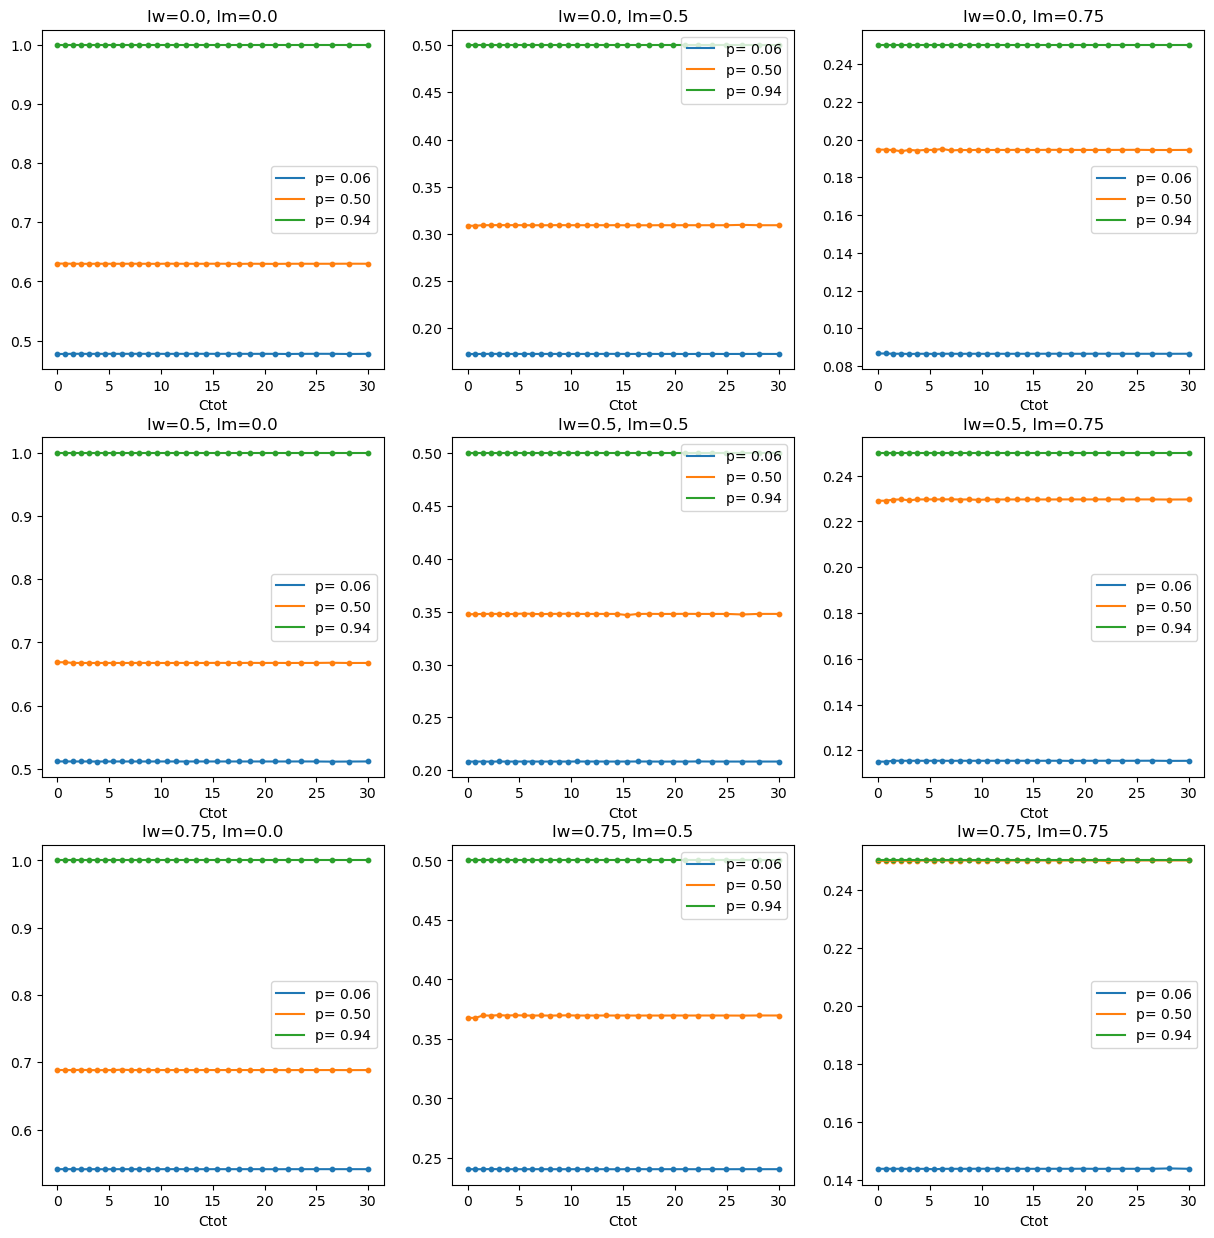

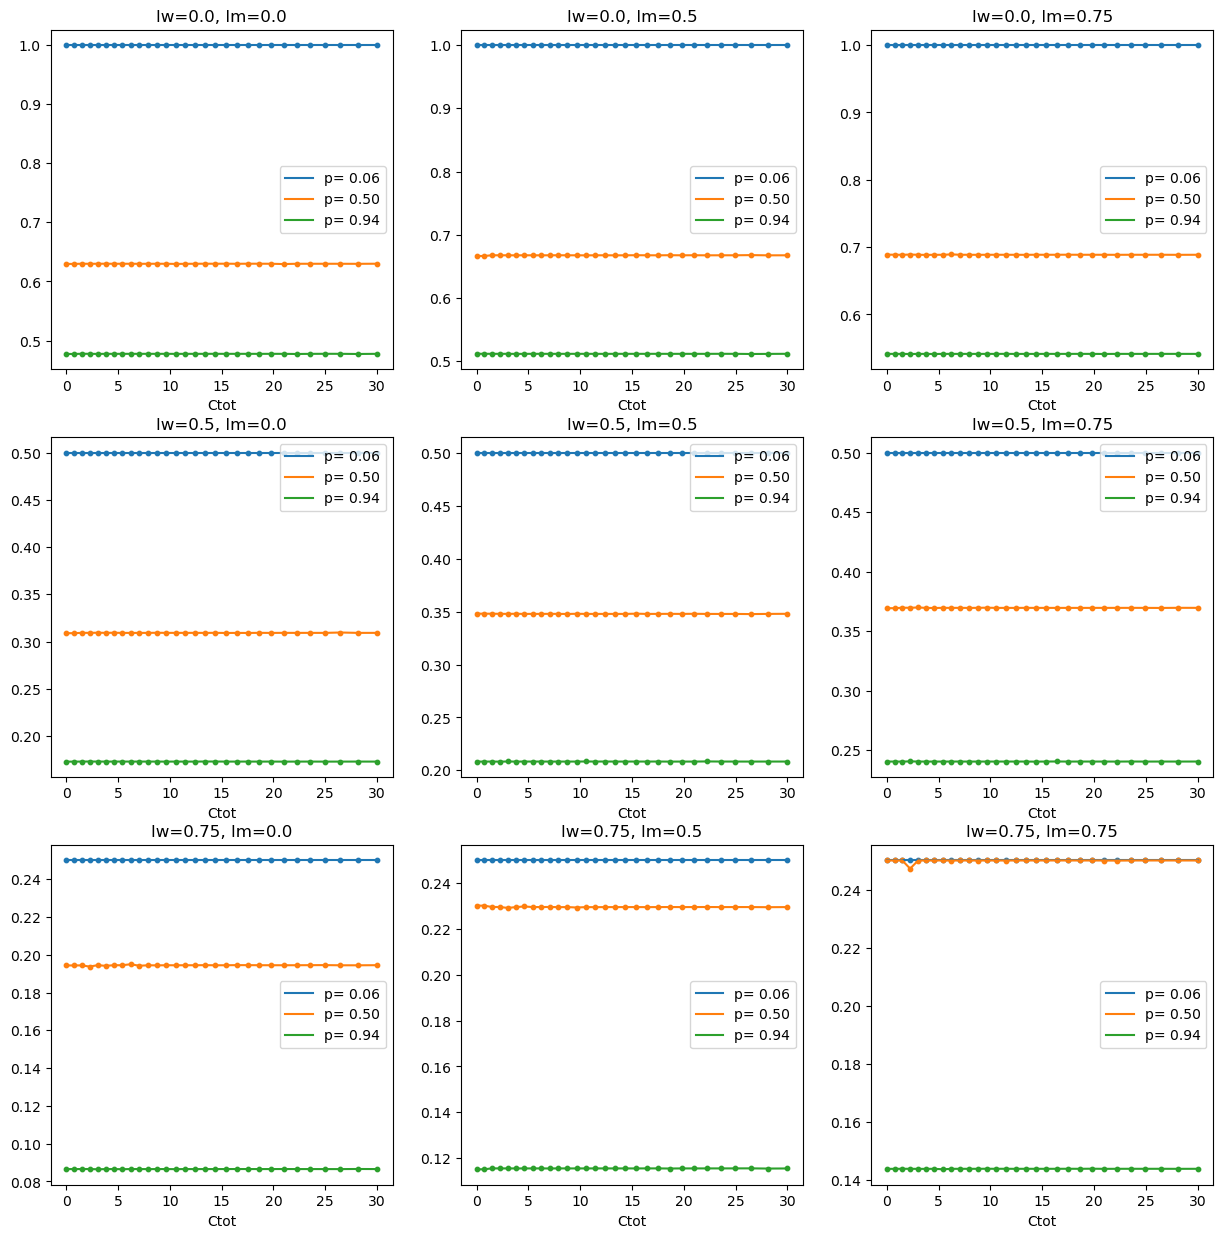

In [19]:
plot_variable_l_by_l('pre_hm_couple', model.sol, iPs, par.grid_Ctot)
plot_variable_l_by_l('pre_hw_couple', model.sol, iPs, par.grid_Ctot)

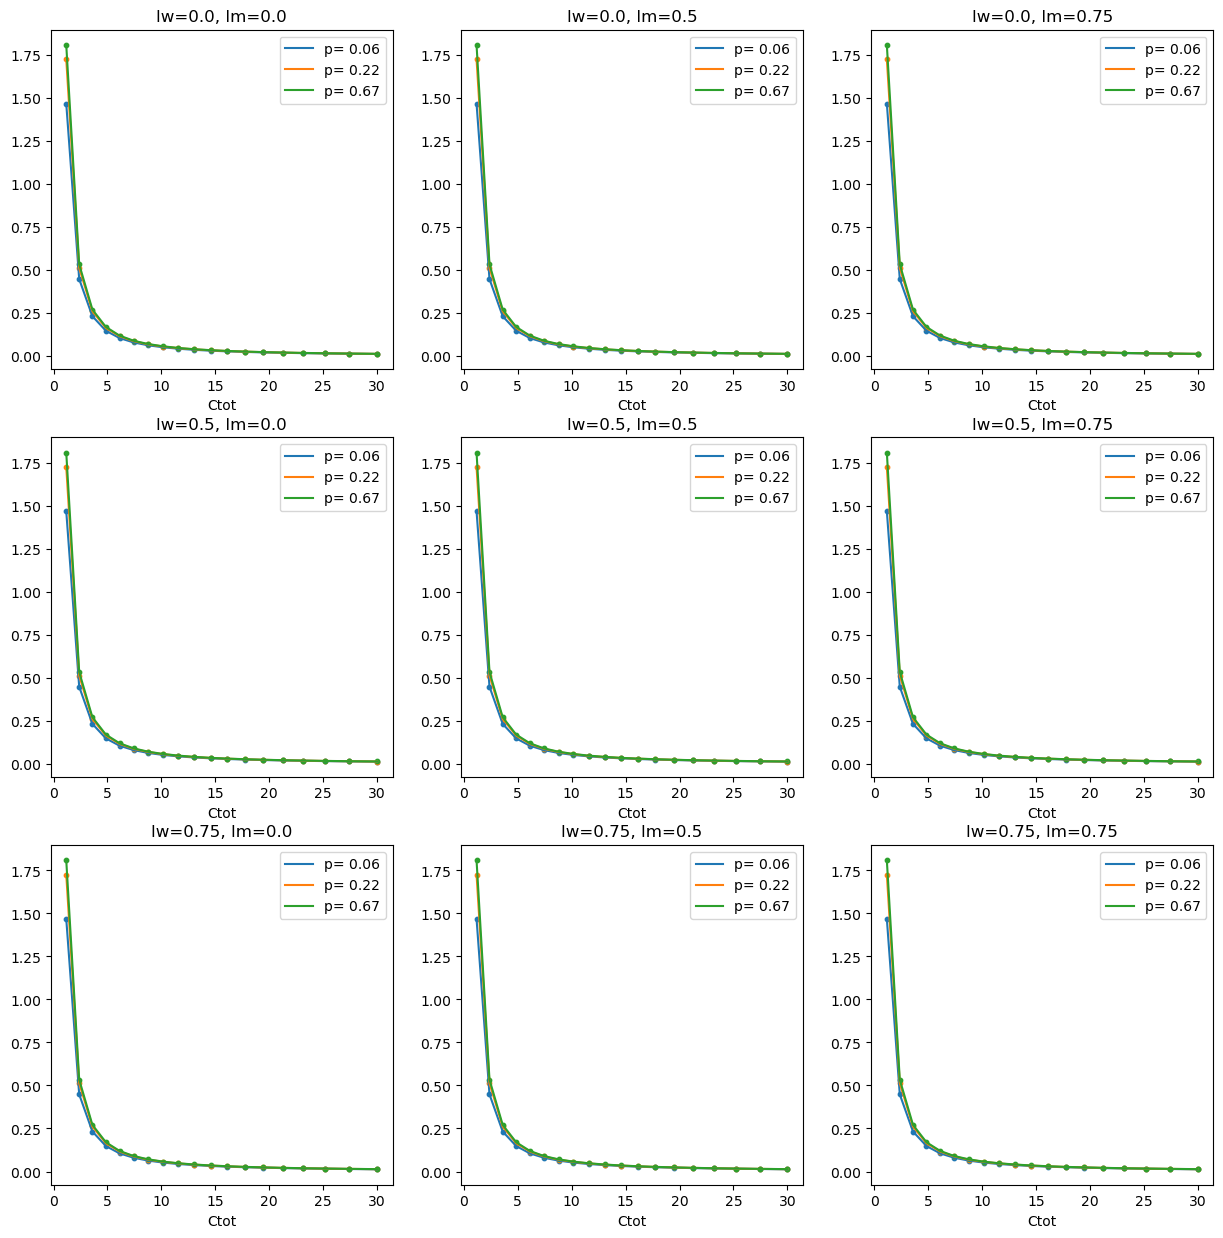

In [20]:
plot_variable_l_by_l('grid_marg_u_couple', model.par, [1, 3, 6], model.par.grid_C_for_marg_u)